In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

In [2]:
def plot_training_hist(training_hist):
    '''
    training_hist: Dataframe constructed from hist.hist from training results.
    '''
    f, a = plt.subplots(1)
    a.plot(training_hist['loss'], label='loss')
    a.plot(training_hist['val_loss'], label='validation loss')
    a.set_xlabel('Epoch')
    a.set_ylabel('Error [Sales Price]')
    a.grid(1)
    a.legend()

In [3]:
def calcate_fig_shape(cols):
    total_figs = len(cols)
    vlen = int(total_figs**0.5)
    hlen = int(np.ceil(total_figs / vlen))
    print(f"Shape of fig: {(vlen, hlen)}")
    return vlen, hlen

def plot_scatter_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        pdf = df[[col, 'SalePrice']].dropna(axis=0)
        ax.scatter(pdf[col], pdf['SalePrice'])
        
    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

def plot_box_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        pdf = df[[col, 'SalePrice']].dropna(axis=0)
        all_cats = df[col].unique()
        ax.boxplot([pdf.loc[pdf[col]==c, 'SalePrice'] for c in all_cats], labels=all_cats)
        if len(all_cats) > 5:
            ax.tick_params(axis='x', labelrotation= 45)
        
    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

def plot_hist_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        all_cats = df[col].unique()
        counts = df[col].value_counts()
        counts = counts / counts.sum() * 100
        ax.bar(counts.index, counts)
        if len(all_cats) > 5:
            ax.tick_params(axis='x', labelrotation= 45)
        ax.set_ylabel('%')

    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

In [4]:
def label_columns(df, cols, label):
    for col in cols:
        df[col] = df[col].map(label).fillna(0).astype(int)

## Data Cleaning
1. NaN values
2. Label the categorical values with order -- 주로 qualitative grade.
    - pd.get_dummy 에서 NaN column사용하는 것도 생각해봐.

In [5]:
train_df = pd.read_csv('rsc/train.csv')
test_df = pd.read_csv('rsc/test.csv')

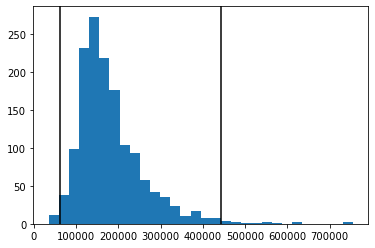

In [6]:
f,a = plt.subplots(1)
_ = a.hist(train_df['SalePrice'], bins=30)
low_thresh = train_df['SalePrice'].quantile(0.01)
high_thresh = train_df['SalePrice'].quantile(0.99)
a.axvline(low_thresh, color='k')
a.axvline(high_thresh, color='k')

### Remove outliers

In [7]:
train_df = train_df.loc[train_df['SalePrice'].between(low_thresh, high_thresh)]

In [8]:
# Columns with NaN. -- I can only work with training data.
nan_count = train_df.isna().sum()
nan_count_table = (nan_count[nan_count >0] / len(train_df) * 100).round(2).to_frame("NaN Precent [%]")
print("Columns that have NaN values:", )
nan_count_table

Columns that have NaN values:


,NaN Precent [%]
LotFrontage,17.97
Alley,93.85
MasVnrType,0.49
MasVnrArea,0.49
BsmtQual,2.45
BsmtCond,2.45
BsmtExposure,2.52
BsmtFinType1,2.45
BsmtFinType2,2.52
Electrical,0.07


In [9]:
# Columns that should not include NaN -- dropthem but only on trainsets.
missing_val = ['Electrical']
print("Train set change:", train_df.shape, '->', train_df.dropna(subset=missing_val).shape)
train_df.dropna(subset=missing_val, inplace=True)

Train set change: (1430, 81) -> (1429, 81)


In [10]:
# Merge Train and test data to Fill NaN values
df= pd.concat([train_df, test_df]).reset_index(drop=True)

In [11]:
# Columns with NA category
na_cat = ['Alley', 'MasVnrType','GarageType', 'MiscFeature']
for c in na_cat:
    df[c] = df[c].fillna('NA')

# Columns that NaN should be zero -- numeric
zero_cat = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for c in na_cat:
    df[c] = df[c].fillna(0)

### Label Qualitative Columns

In [12]:
# columns : labels -- int, qualitative
grading_scheme =[
    (['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'], {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2,'Po':1, np.nan:0}),
    (['BsmtExposure'], {'Gd':4, 'Av':3, 'Mn':2,'No':1, np.nan:0}),
    (['BsmtFinType1', 'BsmtFinType2'], {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3,'LwQ':2,'Unf':1, np.nan:0}),
    (['Functional'], {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4,'Maj1':3,'Maj2':2, 'Sev':1, 'Sal':0}),
    (['GarageFinish'], {'Fin':3, 'RFn':2,'Unf':1, np.nan:0}),
    (['PavedDrive', 'CentralAir'], {'Y':2,'P':1,'N':0}),
    (['Fence'], {'GdPrv':4, 'MnPrv':3, 'GdWo':2,'MnWw':1, np.nan:0})
]
for cols_to_label, label in grading_scheme:
    label_columns(df, cols_to_label, label)

## Feature Selection
### 1. Categorical

In [13]:
# Separate the categorical columns and numeric columns.
categorical_cols = df.dtypes[df.dtypes == object].index
numeric_cols = df.dtypes[df.dtypes != object].index

First, let's look at the categorical features. I want features that are at least somewhat evenly distributed.\
If a feature is not evenly distributed, it cannot be a good distinguishing factor.\
I don't want any feature that has one category dominating more than 70% of the sample.

In [14]:
train_df = df[:len(train_df)]
test_df = df[len(train_df):].drop(columns=['SalePrice'])

In [15]:
def find_unevenly_dist_cols(df, cols):
    '''
    Use this for categorical columns
    '''
    uneven_cat_cols = []
    for c in cols:
        counts = df[c].value_counts()
        counts /= counts.sum()
        if (counts > 0.7).any():
            uneven_cat_cols.append(c)
    return uneven_cat_cols

In [16]:
uneven_cat_cols = find_unevenly_dist_cols(train_df, categorical_cols)
even_cat_cols = set(categorical_cols) - set(uneven_cat_cols)

Shape of fig: (2, 4)


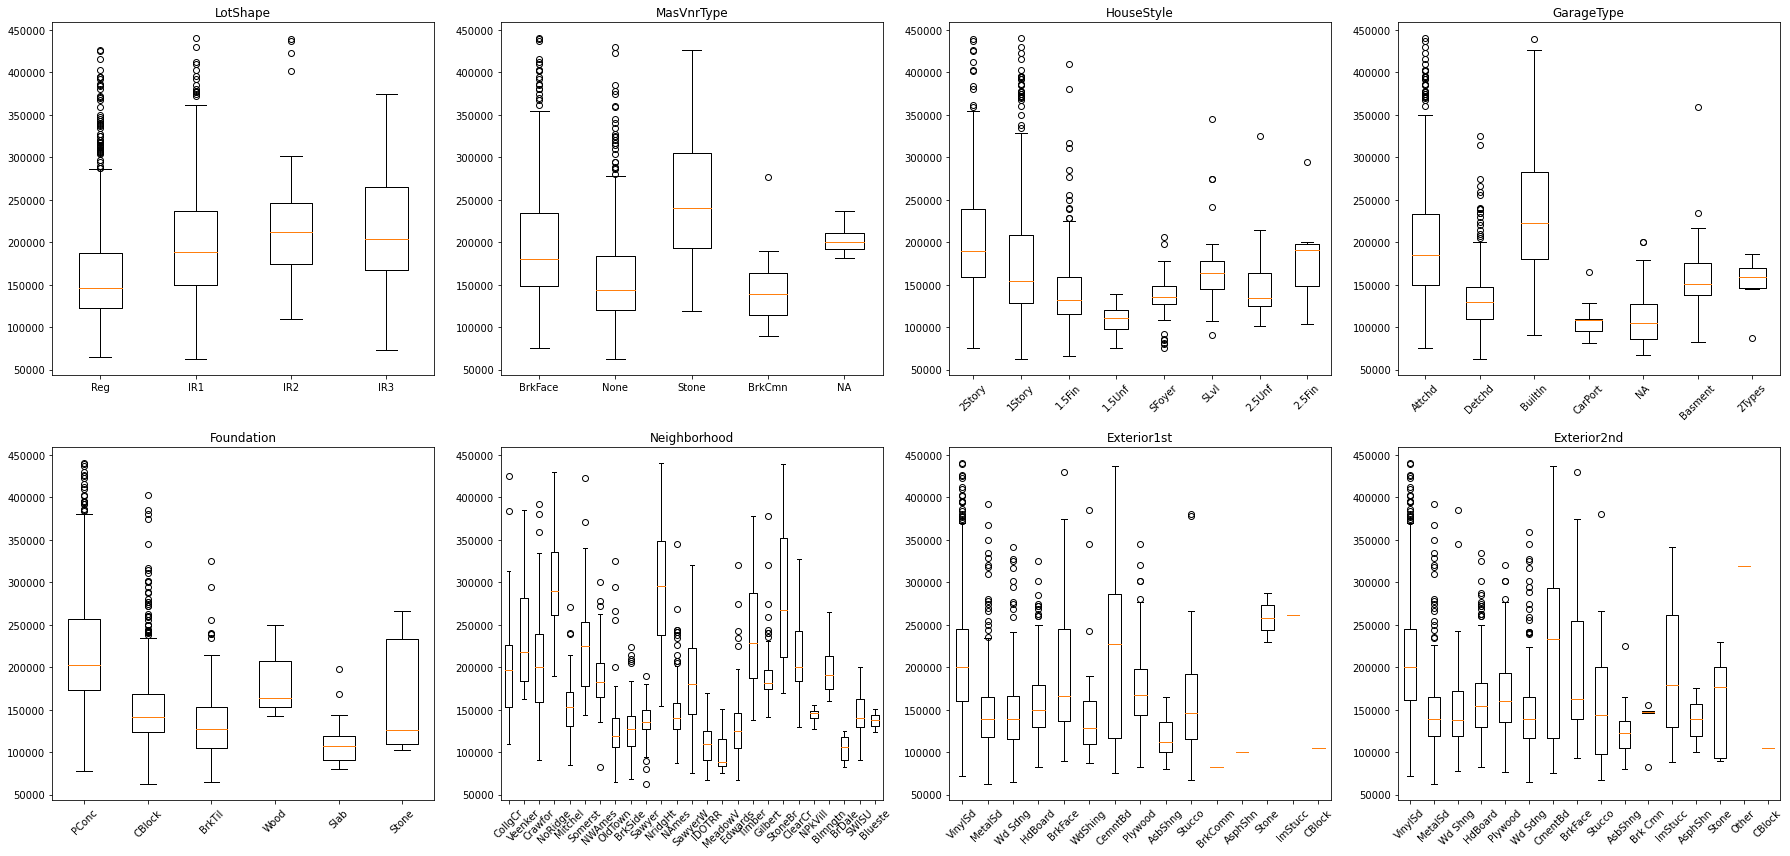

In [17]:
plot_box_matrix(train_df, even_cat_cols)

Most of the features' categories are distinguishing.\
but Exterior features for example, may not be too effective as there are many different categories without significant difference in median.

### 2. Numerical
This set includes qualitative features that were converted to integer values.\
Same procedure goes here. Start with the distribution.

Shape of fig: (7, 8)


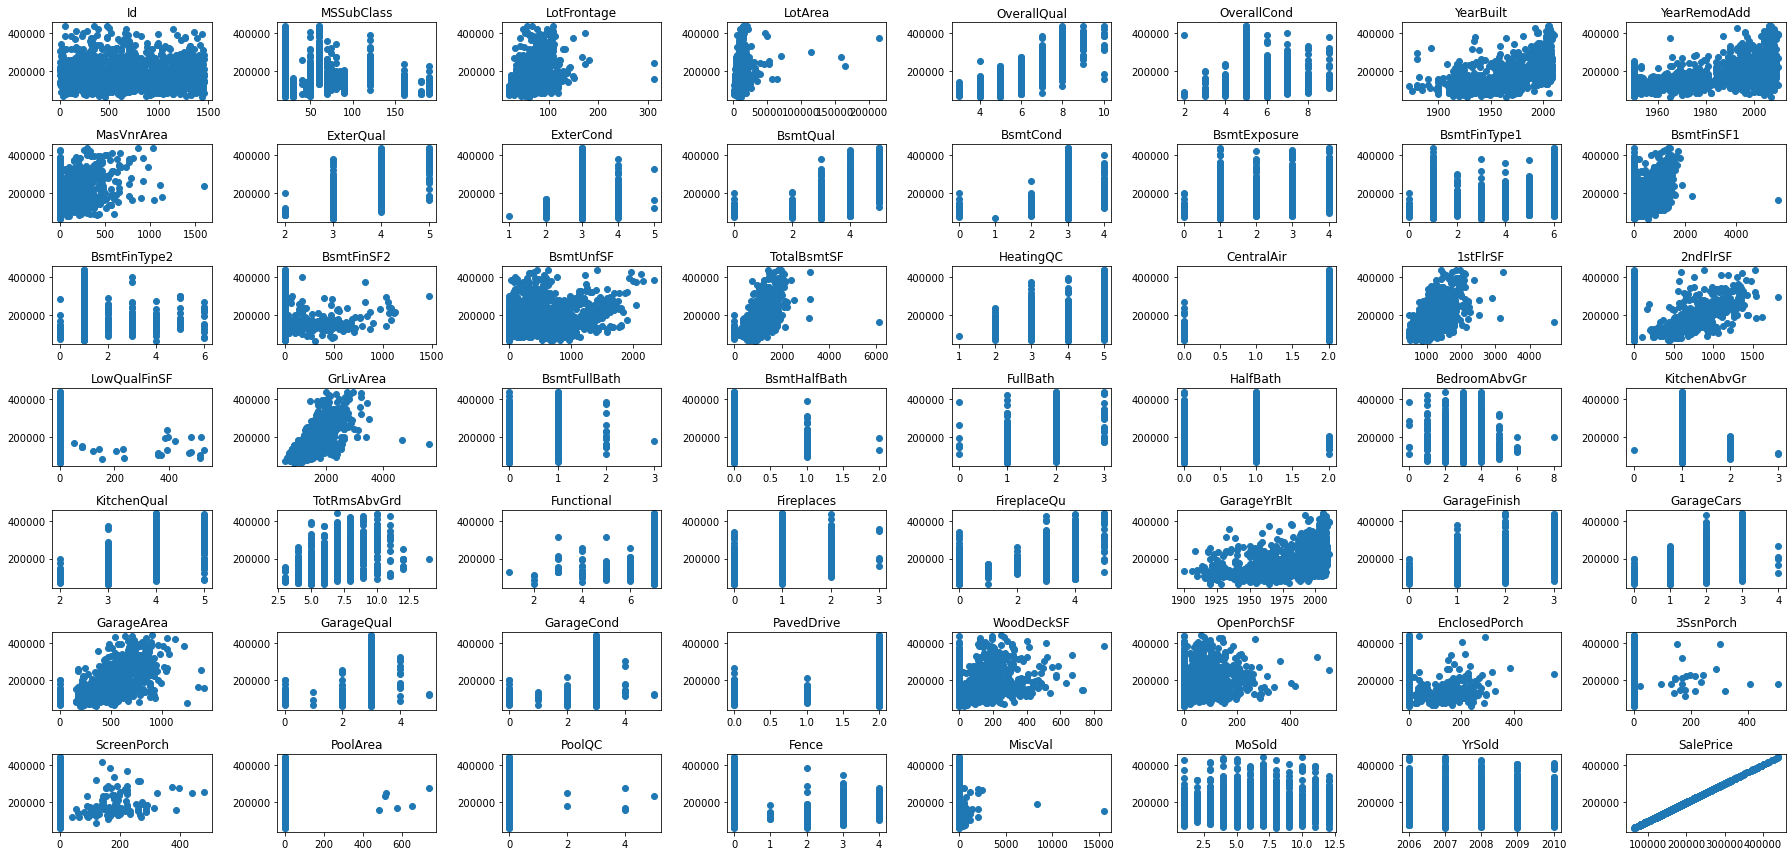

In [18]:
plot_scatter_matrix(train_df, numeric_cols)

It's easy to spot features that have correlations from the graph.\
But let's calculate the correlation coefficient to quantify the relationships.\
I'll be starting with features with correlation coeff higher than 0.5. -- start with the obivous ones.

In [19]:
corr = df[numeric_cols].corr()
strong_numeric_features = corr['SalePrice'][corr['SalePrice'].abs() > 0.5].index
print("strong numeric features", len(strong_numeric_features))
print(strong_numeric_features.tolist())

strong numeric features 16
['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'SalePrice']


In [20]:
def plot_correlation_heatmap(df, cols):
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(df[cols].corr())
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(cols)
    ax.set_title('Correlation plot')
    _ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    _ = cbar.ax.set_ylabel("Pearson score", rotation=-90, va="bottom")

Now, I need to check for colinearity between the strong features.

There seems to be some correlation between the strong features. I need to avoid this. \
Let's quantify this.

In [21]:
def find_high_collinearity(train_df, cols, corr_thresh=0.7):
    corr = train_df[cols].corr()
    sp = corr['SalePrice']
    high_corr = []
    for index, row in corr.iterrows():
        no_dup = row[index:][1:].drop('SalePrice', errors='ignore')  # index is not numeric
        if (no_dup > corr_thresh).any():
            high_corr_found = no_dup.loc[no_dup.abs() > corr_thresh]
            sale_corr = sp[list(high_corr_found.index) + [index]].to_frame().reset_index()
            sale_corr.rename(columns={sale_corr.columns[0]: 'second feature'}, inplace=True)
            sale_corr['first feature'] = index
            sale_corr.set_index(['first feature', 'second feature'], inplace=True)
            high_corr.append(sale_corr)
    high_corr_df = pd.concat(high_corr)#.reset_index(drop=True)
    high_corr_df = high_corr_df.sort_values('SalePrice', ascending=False)
    return high_corr_df

def handle_collinearity(high_corr_df):
    '''
    returns what columns to use considering collinearity.
    '''
    same_basket = dict()
    selected = dict()
    for idx, row in high_corr_df.iterrows():
        if not idx[0] in same_basket:
            if not idx[1] in selected:
                same_basket[idx[0]]=True
                selected[idx[1]]=True
    return selected

In [22]:
high_corr_df = find_high_collinearity(train_df, strong_numeric_features, 0.7)
high_corr_df

SalePrice
first feature second feature           
OverallQual   OverallQual      0.792679
              ExterQual        0.677354
GarageCars    GarageCars       0.642845
              GarageArea       0.620238
TotalBsmtSF   TotalBsmtSF      0.586172
              1stFlrSF         0.575198
YearBuilt     YearBuilt        0.547228
              GarageYrBlt      0.502335

Very interesting. It looks like when Overall Quality is assessed, Exterior Quality is the most emphasized feature. - Makes sense.\
Exterior Quality is strongly correlated to Kitchen Quality. Is it because when they are built/ remodeled, they are the key features that are focused?\
Total Basement SF and 1st Floor SF are correlated because of causality. Foundation == basement >= 1st Floor.
GrLivArea and TotRmsAbvGrd are similarly related. More area to work with -> more rooms can be built.\
Hmmm. Interesting. DNN의 경우에는 multicollinearity에 영향을 받지 않는다고 하네.. source: https://www.cis.upenn.edu/~ungar/Datamining/Publications/tale2.pdf

In [23]:
# selected_numeric = handle_collinearity(high_corr_df)
selected_numeric = strong_numeric_features  # 안하는 게 더 낫다.

In [24]:
print("Categoricals, :", even_cat_cols)
print("Numercals, :", set(selected_numeric))

Categoricals, : {'LotShape', 'MasVnrType', 'HouseStyle', 'GarageType', 'Foundation', 'Neighborhood', 'Exterior1st', 'Exterior2nd'}
Numercals, : {'ExterQual', 'KitchenQual', 'YearRemodAdd', '1stFlrSF', 'GarageYrBlt', 'TotalBsmtSF', 'GrLivArea', 'YearBuilt', 'OverallQual', 'SalePrice', 'FullBath', 'GarageCars', 'FireplaceQu', 'GarageFinish', 'BsmtQual', 'GarageArea'}


### 현재까지 feature engineering 결과:
categorical -> even_categorical_cols\
numerical -> numeric_columns

In [25]:
df_onehot = pd.get_dummies(df, columns=even_cat_cols, drop_first=True)
train_dataset = df_onehot[:len(train_df)]
test_dataset = df_onehot[len(train_df):]
target = df[:len(train_df)]['SalePrice']

In [26]:
# Trial & Error
final_features = ['OverallQual', 'YearBuilt','YearRemodAdd', 'ExterQual','BsmtQual','TotalBsmtSF','GrLivArea', 'GarageCars',
                            *train_dataset.columns[train_dataset.columns.map(lambda x: x.startswith('LotShape'))],
                            *train_dataset.columns[train_dataset.columns.map(lambda x: x.startswith('Neighborhood'))],
                            'KitchenQual', 'GarageArea'
                 ]
train_input= train_dataset[final_features]
test_input = test_dataset[final_features]
# 역효과: 'FullBath', 'FireplaceQu','GarageFinish', 'Foundation', 'Exterior1st', 'GarageType', 'MasVnrType', 'Exterior2nd', 'HouseStyle'